# 滴滴比赛

导入必须的！

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 文件位置

In [3]:

base_dir = "G:/project/dataset/didi/season_1/training_data"

train_cluster_map_file = os.path.join(base_dir, 'cluster_map', 'cluster_map')
train_poi_file = os.path.join(base_dir, 'poi_data', 'poi_data')
#train_order_file = os.path.join(base_dir, 'order_data', 'order_data_2016-01-21')
#train_cluster_map = os.path.join(base_dir, 'cluster_map')
train_order_file = os.path.join(base_dir, 'order_data', 'order_data.csv')

train_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')

all_traffic_file = os.path.join(base_dir, 'traffic_data', 'all_traffic.csv')

test_base_dir = "G:/project/dataset/didi/season_1/test_set_1"
test_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')

## 区域 hashid 和 实际id

cluster_map 数据， pandas 应该比 dict 快， 到时候 merge 或 join 比 从 dict 里找好。

In [4]:
cluster_map = pd.read_csv(train_cluster_map_file, sep="\t", header=None, names=['hashid', 'id'])

In [13]:
print len(cluster_map)

66


In [65]:
cluster_map[:2]

,hashid,id
0,90c5a34f06ac86aee0fd70e2adce7d8a,1
1,f2c8c4bb99e6377d21de71275afd6cd2,2


## 复习下 pandas 读数据

1. 复习下数据读取, read_csv
2. 个人认为不需要的数据， 如 order_id 等id， 该省略的省掉（order_id, passenger_id, dest_district_has）， 该转换的转换, driver_id 变成是否有接单， 时间拆出日期和时间片， start_distrct_hash 改成实际id。 节省空间。去掉一堆 hash的字符串， 可以省很多空间

**也许有些信息还有用， 觉得有用时再补充回来**


In [9]:
# 时：分：秒 转成 10分钟的时间片
def time2Slice(time_str):
    l = time_str.split(":")
    return int(l[0]) * 6 + int(l[1]) / 10 + 1

In [8]:
# Order data 的数据 hash 太多， 顺便复习下 pandas
def reduceOrderFile(base_name, f):
    import time
    prev = time.time()
    fname = os.path.join(base_name, f)
    order = pd.read_csv(fname, sep="\t", header=None, dtype={'Price': np.str},
                          names=['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash',
                                'Price', 'Time'])

    full_order = order.merge(cluster_map, left_on='start_district_hash', right_on='hashid')

    full_order['Date'] = pd.Series([e.split()[0] for e in full_order['Time']])

    full_order['TimePiece'] = pd.Series([time2Slice(e.split()[1]) for e in full_order['Time']])

    full_order['Resp'] = full_order['driver_id'].notnull()

    small_order = full_order.loc[:, ['Date', 'TimePiece', 'id', 'Price', 'Resp']]
    small_order_file = os.path.join(base_name, f + ".csv")
    small_order.to_csv(small_order_file, index = False)
    print time.time() - prev
    
    #return small_order

In [7]:
# 测试函数

def testReduceOrder():
    z = reduceOrderFile('G:/project/dataset/citydata/season_1/training_data\order_data', 'order_data_2016-01-21')
    print len(z)
    print sum(z['Resp'])

In [6]:
# 批量 order reduce
def reduceFiles(base_name):
    for rt, dirs, files in os.walk(base_name):
        for f in files:           
            reduceOrderFile(base_name, f)


In [11]:
# 运行过就不要再来了， 一个文件6秒， 20个文件， 还是要2分钟的。
def runForOnce():
    
    reduceFiles(os.path.join(test_base_dir, 'order_data'))

In [43]:
def test_read_order():
    train_order = pd.read_csv(train_order_file, sep="\t", header=None, dtype={'Price': np.float, 'driver_id': np.str},
                          names=['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash',
                                'Price', 'Time'])
    print len(train_order)
    t = train_order['driver_id']
    print t.notnull()
    small_order = full_train_order.loc[:, ['Date', 'TimePiece', 'id', 'Price', 'Resp']]

# 读取 order 数据

训练和测试数据

训练数据 训练 验证

In [12]:
train_order = pd.read_csv(train_order_file, dtype={'TimePiece': np.int16, 'id': np.int16, 'Price': np.float, 'Resp': np.bool})
train_order[:2]

,Date,TimePiece,id,Price,Resp
0,2016-01-01,82,23,24,True
1,2016-01-01,87,23,5,True


## 数据分组

区域 日期 时间片

In [24]:
group_all = train_order.loc[:, ['id', 'Date', 'TimePiece', 'Resp']].groupby(['id', 'Date', 'TimePiece'])

In [25]:
sd_data = group_all.count()
sd_data[:3]

Resp
id Date       TimePiece      
1  2016-01-01 1           187
              2           198
              3           192

In [26]:
sd_data['supply'] = group_all.Resp.sum()
sd_data[:3]

Resp  supply
id Date       TimePiece              
1  2016-01-01 1           187     178
              2           198     191
              3           192     182

In [27]:
sd_data['gap'] = sd_data.Resp - sd_data.supply
sd_data[:3]

Resp  supply  gap
id Date       TimePiece                   
1  2016-01-01 1           187     178    9
              2           198     191    7
              3           192     182   10

In [29]:
sd_data.columns = ['demand', 'supply', 'gap']
sd_data.describe()

,demand,supply,gap
count,163491.000000,163491.000000,163491.000000
mean,52.239047,42.963552,9.275495
std,112.348401,81.039485,49.817422
min,1.000000,0.000000,0.000000
25%,4.000000,3.000000,0.000000
50%,12.000000,10.000000,1.000000
75%,47.000000,41.000000,4.000000
max,4362.000000,1084.000000,3872.000000


In [32]:
sd_data.gap.argmax()

(51, '2016-01-01', 6)

In [33]:
sd_data[:3]

demand  supply  gap
id Date       TimePiece                     
1  2016-01-01 1             187     178    9
              2             198     191    7
              3             192     182   10

## 索引改列


In [34]:
sd_df = sd_data.reset_index(level = ['id', 'Date', 'TimePiece'])

sd_df[:5]

,id,Date,TimePiece,demand,supply,gap
0,1,2016-01-01,1,187,178,9
1,1,2016-01-01,2,198,191,7
2,1,2016-01-01,3,192,182,10
3,1,2016-01-01,4,172,167,5
4,1,2016-01-01,5,153,152,1


In [38]:
sd_df.sort_values('demand', ascending=False)[:3]

,id,Date,TimePiece,demand,supply,gap
130048,51,2016-01-01,6,4362,490,3872
130047,51,2016-01-01,5,4296,512,3784
130049,51,2016-01-01,7,4056,454,3602


In [42]:
sd_df[sd_df.Date == test_date].groupby('TimePiece').gap.sum()

TimePiece
1       121
2       515
3      2270
4      4463
5      5326
6      5363
7      4809
8      4487
9      3861
10     3342
11     2604
12     1991
13     1823
14     1758
15     1675
16     1447
17     1088
18     1062
19     1066
20      940
21      672
22      624
23      473
24      482
25      512
26      508
27      526
28      490
29      516
30      540
       ... 
115     155
116     163
117     155
118     145
119     194
120     194
121     153
122     146
123     153
124     162
125     157
126     174
127     147
128     127
129     166
130     138
131     141
132     107
133     146
134     134
135     106
136     108
137      89
138     113
139     105
140     114
141     113
142     185
143     298
144     275
Name: gap, dtype: float64

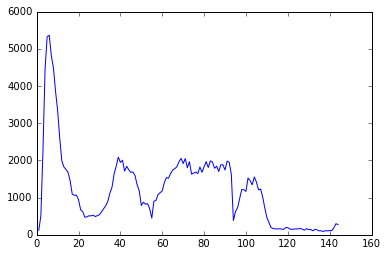

In [47]:
d = 1
test_date = '2016-01-%02d' % d
serial = sd_df[sd_df.Date == test_date].groupby('TimePiece').gap.sum()
plt.plot(serial)

## 查看各天的总gap 情况

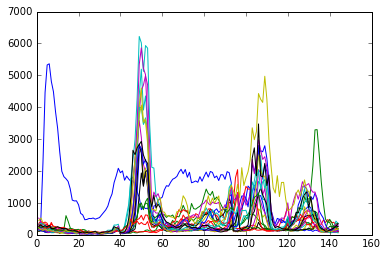

In [49]:
test_date = '2016-01-11'
for d in range(1, 22):
    test_date = '2016-01-%02d' % d
    serial = sd_df[sd_df.Date == test_date].groupby('TimePiece').gap.sum()
    plt.plot(serial)

In [ ]:
for d in range(2, 22):
    test_date = '2016-01-%02d' % d
    serial = sd_df[sd_df.Date == test_date].groupby('TimePiece').gap.sum()
    serial2 = sd_df[sd_df.Date == test_date].groupby('TimePiece').demand.sum()
    serial3 = sd_df[sd_df.Date == test_date].groupby('TimePiece').supply.sum()
    plt.figure()
    plt.title(test_date)
    plt.xlim(0, 144)
    plt.plot(serial, label='gap')
    plt.plot(serial2)
    plt.plot(serial3)

In [4]:
district_group = train_order.groupby('id')

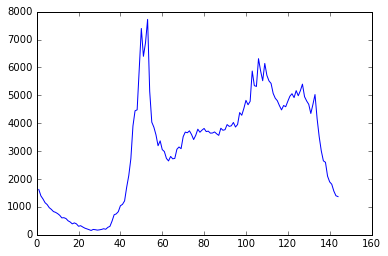

In [20]:
serial = district_group.get_group(1).groupby('TimePiece').Resp.count()
plt.plot(serial)

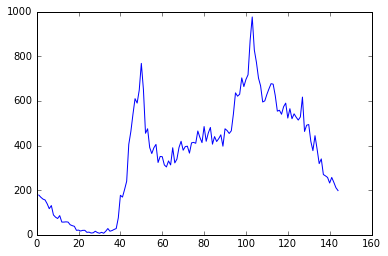

In [23]:
serial2 = district_group.get_group(2).groupby('TimePiece').Resp.count()
plt.plot(serial2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


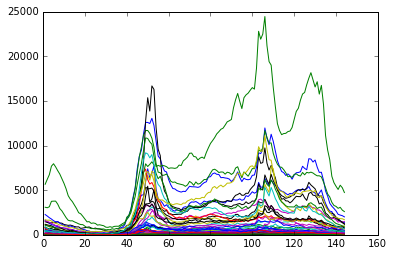

In [5]:
for name, group in district_group:
    #group.groupBy('TimePiece').Resp.count()
    serial = group.groupby('TimePiece').Resp.count()
    plt.plot(serial)

In [4]:
train_traffic = pd.read_csv(train_traffic_file, sep="\t", header=None,
                          names=['hashid', 'traffic1', 'traffic2', 'traffic3', 'traffic4', 'Time'])

In [10]:
len(train_traffic)

193553

In [113]:
def deal_traffic(traffic_file):
    traffic_data = pd.read_csv(traffic_file, sep="\t", header=None,
                          names=['hashid', 'traffic1', 'traffic2', 'traffic3', 'traffic4', 'Time'])
    traffic_data['Date'] = pd.Series([e.split()[0] for e in traffic_data['Time']])
    traffic_data['TimePiece'] = pd.Series([time2Slice(e.split()[1]) for e in traffic_data['Time']])
    traffic_data.traffic1 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic1])
    traffic_data.traffic2 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic2])
    traffic_data.traffic3 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic3])
    traffic_data.traffic4 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic4])
    
    traffic_data['traffic'] = pd.Series((traffic_data.traffic1 + traffic_data.traffic2 * 2 + traffic_data.traffic3 * 3 + traffic_data.traffic4 * 4)
                                  * 0.1 /(traffic_data.traffic1 + traffic_data.traffic2 + traffic_data.traffic3 + traffic_data.traffic4) )
    traffic_min = traffic_data['traffic'].min()
    traffic_max = traffic_data['traffic'].max()

    print traffic_max, traffic_min
    
    traffic_data['traffic'] = (traffic_data['traffic'] - traffic_min) / (traffic_max - traffic_min)
    
    small_traffic = traffic_data.loc[:, ['hashid', 'Date', 'TimePiece', 'traffic']]
    return small_traffic.sort_values(['hashid', 'Date', 'TimePiece'])

In [114]:
# all_traffic_file
all_traffic = deal_traffic(all_traffic_file)

0.4 0.1


In [116]:
all_traffic.describe()

,TimePiece,traffic
count,201934.000000,201934.000000
mean,73.537913,0.094944
std,41.009222,0.043510
min,2.000000,0.000000
25%,39.000000,0.066667
50%,74.000000,0.093333
75%,109.000000,0.122040
max,144.000000,1.000000


In [118]:
small_traffic_file = os.path.join(base_dir, "traffic.csv")
all_traffic.to_csv(small_traffic_file, index = False)

In [7]:
train_traffic['Date'] = pd.Series([e.split()[0] for e in train_traffic['Time']])
train_traffic['TimePiece'] = pd.Series([time2Slice(e.split()[1]) for e in train_traffic['Time']])


In [13]:
train_traffic.traffic1 = pd.Series([ int(e.split(':')[1]) for e in train_traffic.traffic1])

In [14]:
train_traffic.traffic1 = pd.Series([ int(e.split(':')[1]) for e in train_traffic.traffic1])
train_traffic.traffic2 = pd.Series([ int(e.split(':')[1]) for e in train_traffic.traffic2])
train_traffic.traffic3 = pd.Series([ int(e.split(':')[1]) for e in train_traffic.traffic3])
train_traffic.traffic4 = pd.Series([ int(e.split(':')[1]) for e in train_traffic.traffic4])

In [95]:
train_traffic['traffic'] = pd.Series((train_traffic.traffic1 + train_traffic.traffic2 * 2 + train_traffic.traffic3 * 3 + train_traffic.traffic4 * 4)
                                  * 0.1 /(train_traffic.traffic1 + train_traffic.traffic2 + train_traffic.traffic3 + train_traffic.traffic4) )

In [98]:
traffic_min = train_traffic['traffic'].min()
traffic_max = train_traffic['traffic'].max()



In [99]:
print traffic_max, traffic_min

0.4 0.1


In [100]:
train_traffic['traffic'] = (train_traffic['traffic'] - traffic_min) / (traffic_max - traffic_min)

In [57]:
traffic_20 = train_traffic[train_traffic.Date == '2016-01-20']

In [103]:
train_traffic[:10]

,hashid,traffic1,traffic2,traffic3,traffic4,Time,Date,TimePiece,traffic,traffic_re
0,1ecbb52d73c522f184a6fc53128b1ea1,231,33,13,10,2016-01-01 23:30:22,2016-01-01,142,1.033682e-01,-1.319697
1,1ecbb52d73c522f184a6fc53128b1ea1,305,69,13,16,2016-01-01 09:10:25,2016-01-01,56,1.182796e-01,-0.767423
2,bf44d327f0232325c6d5280926d7b37d,579,87,28,16,2016-01-01 21:50:27,2016-01-01,132,8.967136e-02,-1.826987
3,bf44d327f0232325c6d5280926d7b37d,242,28,10,9,2016-01-01 06:20:15,2016-01-01,39,8.650519e-02,-1.944252
4,bf44d327f0232325c6d5280926d7b37d,471,35,15,17,2016-01-01 00:50:26,2016-01-01,6,7.187113e-02,-2.486255
5,bf44d327f0232325c6d5280926d7b37d,401,98,64,28,2016-01-01 13:50:25,2016-01-01,84,1.748449e-01,1.327589
6,f2c8c4bb99e6377d21de71275afd6cd2,593,242,42,22,2016-01-01 17:20:31,2016-01-01,105,1.453467e-01,0.235062
7,f2c8c4bb99e6377d21de71275afd6cd2,570,41,21,28,2016-01-01 03:10:19,2016-01-01,20,8.434343e-02,-2.024317
8,f2c8c4bb99e6377d21de71275afd6cd2,706,129,23,17,2016-01-01 09:20:24,2016-01-01,57,8.609524e-02,-1.959436
9,d5cb17978de290c56e84c9cf97e63186,11,0,0,0,2016-01-01 04:00:17,2016-01-01,25,4.625929e-17,-5.148148


In [104]:
small_traffic = train_traffic.loc[:, ['hashid', 'Date', 'TimePiece', 'traffic']]

In [108]:
small_traffic.sort_values(['hashid', 'Date', 'TimePiece'])

,hashid,Date,TimePiece,traffic
7354,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,2,0.075000
7540,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,3,0.127854
7732,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,4,0.161994
7923,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,5,0.117460
8108,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,6,0.011396
8290,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,7,0.121212
8478,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,8,0.162037
8677,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,9,0.110193
2348,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,10,0.137255
2532,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,11,0.075758


In [101]:
train_traffic.describe()

,traffic1,traffic2,traffic3,traffic4,TimePiece,traffic,traffic_re
count,193553.000000,193553.000000,193553.00000,193553.000000,193553.000000,193553.000000,193553.000000
mean,603.522338,128.780282,38.72173,26.097756,72.641271,0.094765,-1.638324
std,704.277587,216.896741,67.77862,42.035663,41.189142,0.043623,1.615654
min,0.000000,0.000000,0.00000,0.000000,2.000000,0.000000,-5.148148
25%,147.000000,16.000000,5.00000,3.000000,37.000000,0.066425,-2.687958
50%,323.000000,49.000000,15.00000,10.000000,73.000000,0.093114,-1.699473
75%,779.000000,146.000000,43.00000,30.000000,108.000000,0.121875,-0.634259
max,4223.000000,2084.000000,863.00000,486.000000,144.000000,1.000000,31.888889


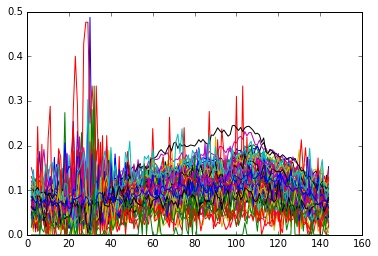

In [102]:
traffic_21 = train_traffic[train_traffic.Date == '2016-01-09']

for name, group in traffic_21.groupby('hashid'):
    plt.plot(group.groupby(['TimePiece']).traffic.sum())
    

In [25]:
small_traffic = train_traffic.merge(cluster_map, left_on='hashid', right_on='hashid')#\
                            #.loc[:, ['hashid', 'Date', 'TimePiece', 'Price', 'Resp']]

In [34]:
smallforgroup = small_traffic.loc[:, ['id', 'Date', 'TimePiece', 'traffic']]

In [45]:
groupall = smallforgroup.groupby(['id', 'Date'])

In [55]:
groupall.traffic.count()

id  Date      
1   2016-01-01    143
    2016-01-02    143
    2016-01-03    143
    2016-01-04    143
    2016-01-05    143
    2016-01-06    143
    2016-01-07    143
    2016-01-08    143
    2016-01-09    143
    2016-01-10    143
    2016-01-11    143
    2016-01-12    143
    2016-01-13    143
    2016-01-14    143
    2016-01-15    143
    2016-01-16    143
    2016-01-17    143
    2016-01-18    143
    2016-01-19    143
    2016-01-20    120
    2016-01-21    143
2   2016-01-01    143
    2016-01-02    143
    2016-01-03    143
    2016-01-04    143
    2016-01-05    143
    2016-01-06    143
    2016-01-07    143
    2016-01-08    143
    2016-01-09    143
                 ... 
65  2016-01-13    143
    2016-01-14    143
    2016-01-15    143
    2016-01-16    143
    2016-01-17    143
    2016-01-18    143
    2016-01-19    143
    2016-01-20    120
    2016-01-21    143
66  2016-01-01    143
    2016-01-02    143
    2016-01-03    143
    2016-01-04    143
    2016-01-05   

In [ ]:
train_traffic.sort